# **Importing Libraries**



Install the necessary Python libraries for data manipulation, machine learning, and optimization.


In [7]:
%pip install pandas numpy matplotlib prophet xgboost scikit-learn optuna seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import necessary libraries for data manipulation, visualization, machine learning, and model optimization.

In [8]:
# Warnings and logging handling
import warnings
import logging
import optuna
import cmdstanpy

# Suppress warnings and configure logging
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.ERROR)
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Time series forecasting
from prophet import Prophet

# Suppress warnings and configure logging
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.ERROR)
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="optuna")

# Machine learning libraries
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Optimization libraries
from optuna import create_study
from optuna.samplers import TPESampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="optuna")

# Use the following before pip install cells:
# %capture

# Data Preprocessing
### Loading and Inspecting the Dataset


In [9]:
df = pd.read_csv('dataset/CodeChallenge_Dataset_2021-2023_Set 2.csv')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417319 entries, 0 to 417318
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   InvoiceId   417319 non-null  int64  
 1   Date        417319 non-null  object 
 2   CustomerId  417319 non-null  object 
 3   ProductId   417319 non-null  object 
 4   Quantity    417319 non-null  int64  
 5   Amount      417319 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 19.1+ MB


As we can see, the date format is object. We need convert it into Datetime format before proceeding.

In [11]:
df

,InvoiceId,Date,CustomerId,ProductId,Quantity,Amount
0,6319443,28/12/2023,D-2228168,P-1723306,1,29.33
1,6319433,28/12/2023,D-2228168,P-3542260,1,15.24
2,6319433,28/12/2023,D-2228168,P-3542258,1,15.24
3,6319432,28/12/2023,D-2228168,P-3542260,1,15.40
4,6319411,28/12/2023,D-2228168,P-4467865,1,7.48
...,...,...,...,...,...,...
417314,1396796,07/01/2021,D-98141,P-796828,20,237.60
417315,1396796,07/01/2021,D-98141,P-796828,12,108.36
417316,1396796,07/01/2021,D-98141,P-796828,24,265.68
417317,1396796,07/01/2021,D-98141,P-796828,144,578.88


Remove dates with 00:00 string in the column, to make the Date column consistent

In [12]:
df['Date'] = df['Date'].apply(lambda x: x.replace(' 00:00', '') if isinstance(x, str) and '00:00' in x else x)


Convert Date to datetime format

In [13]:
df['DATE'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)


Sort the date ascendingly

In [14]:
df.sort_values(by='DATE', inplace=True)

In [15]:
df

,InvoiceId,Date,CustomerId,ProductId,Quantity,Amount,DATE
417318,1396795,01/01/2021,D-37788,P-796828,40,432.00,2021-01-01
415667,1398094,01/01/2021,D-354562,P-796828,36,104.40,2021-01-01
415668,1398094,01/01/2021,D-354562,P-796828,24,37.20,2021-01-01
415669,1398094,01/01/2021,D-354562,P-796828,20,220.00,2021-01-01
415670,1398094,01/01/2021,D-354562,P-796828,30,151.80,2021-01-01
...,...,...,...,...,...,...,...
1064,5949568,31/12/2023,D-346261,P-796828,1,21415.73,2023-12-31
1063,5950733,31/12/2023,D-357945,P-796828,1,39095.73,2023-12-31
1059,5972341,31/12/2023,D-344605,P-796828,1,130.00,2023-12-31
1049,6138348,31/12/2023,D-357945,P-796828,1,1750.00,2023-12-31


Check for any null value in the dataset

In [16]:
df.isna().sum()

InvoiceId     0
Date          0
CustomerId    0
ProductId     0
Quantity      0
Amount        0
DATE          0
dtype: int64

Remove the row, if there are any column from (ProductId, Quantity,Amount) affected with null value

In [17]:
df = df.dropna(subset=['ProductId', 'Quantity', 'Amount'])


Drop Date, because we already created DATE for standardization

In [18]:
df = df.drop('Date', axis=1)

Check for any negative value in Amount

In [19]:
negative_amount_count = (df['Amount'] < 0).sum()
print(f"Number of negative values in 'Amount' column: {negative_amount_count}")


Number of negative values in 'Amount' column: 1


Remove rows with negative amount

In [20]:
df = df[df['Amount'] >= 0]


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417318 entries, 417318 to 1050
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   InvoiceId   417318 non-null  int64         
 1   CustomerId  417318 non-null  object        
 2   ProductId   417318 non-null  object        
 3   Quantity    417318 non-null  int64         
 4   Amount      417318 non-null  float64       
 5   DATE        417318 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 22.3+ MB


Make DATE as the first column

In [22]:
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]


In [23]:
df

,DATE,InvoiceId,CustomerId,ProductId,Quantity,Amount
417318,2021-01-01,1396795,D-37788,P-796828,40,432.00
415667,2021-01-01,1398094,D-354562,P-796828,36,104.40
415668,2021-01-01,1398094,D-354562,P-796828,24,37.20
415669,2021-01-01,1398094,D-354562,P-796828,20,220.00
415670,2021-01-01,1398094,D-354562,P-796828,30,151.80
...,...,...,...,...,...,...
1064,2023-12-31,5949568,D-346261,P-796828,1,21415.73
1063,2023-12-31,5950733,D-357945,P-796828,1,39095.73
1059,2023-12-31,5972341,D-344605,P-796828,1,130.00
1049,2023-12-31,6138348,D-357945,P-796828,1,1750.00


# Sales Analysis
Check how many unique variable on each column

In [24]:
unique = df.nunique()
unique

DATE            1042
InvoiceId     212591
CustomerId      2538
ProductId        518
Quantity        1348
Amount         21363
dtype: int64

In [25]:
df[['Amount', 'Quantity']].describe()


,Amount,Quantity
count,417318.000000,417318.000000
mean,355.375987,93.179865
std,2008.302332,1092.680454
min,0.000000,0.000000
25%,9.700000,1.000000
50%,27.600000,2.000000
75%,120.960000,24.000000
max,199717.860000,156600.000000


In [26]:
df.describe(include=['object'])


,CustomerId,ProductId
count,417318,417318
unique,2538,518
top,D-357699,P-796828
freq,177770,230935


### Check the total amount for each month from 2021-2023,percentage change, and statistics


In [27]:
import pandas as pd

def analyze_monthly_sales(df):
    """
    Analyze total sales amount by month with year-over-year comparison
    """
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Calculate monthly totals
    monthly_sales = df.groupby(df['DATE'].dt.to_period('M'))['Amount'].sum()

    # Convert to DataFrame and reset index for better formatting
    monthly_df = monthly_sales.reset_index()
    monthly_df.columns = ['Date', 'Total']

    # Extract year and month from the Date column
    monthly_df['Year'] = monthly_df['Date'].dt.year
    monthly_df['Month'] = monthly_df['Date'].dt.month

    # Add month names
    month_names = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April',
        5: 'May', 6: 'June', 7: 'July', 8: 'August',
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }
    monthly_df['Month'] = monthly_df['Month'].map(month_names)

    print("\n=== Monthly Sales Analysis (2021-2023) ===")
    print("-" * 50)
    print(f"{'Year':<6}{'Month':<12}{'Total Sales':>15}{'% Change':>12}")
    print("-" * 50)

    # Print monthly totals with year-over-year comparison
    previous_year_amount = None
    current_year = None

    for _, row in monthly_df.iterrows():
        if current_year != row['Year']:
            current_year = row['Year']
            print("-" * 50)  # Separator between years

        amount = row['Total']

        # Calculate year-over-year change
        if previous_year_amount:
            yoy_change = ((amount - previous_year_amount) / previous_year_amount) * 100
            change_str = f"{yoy_change:>+11.1f}%"
        else:
            change_str = " " * 12

        print(f"{row['Year']:<6}{row['Month']:<12}${amount:>14,.2f}{change_str}")

        previous_year_amount = amount

    # Summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total Sales: ${monthly_df['Total'].sum():,.2f}")
    print(f"Average Monthly Sales: ${monthly_df['Total'].mean():,.2f}")
    print(f"Highest Month: {monthly_df.loc[monthly_df['Total'].idxmax(), 'Month']} "
          f"{monthly_df.loc[monthly_df['Total'].idxmax(), 'Year']}"
          f" (${monthly_df['Total'].max():,.2f})")
    print(f"Lowest Month: {monthly_df.loc[monthly_df['Total'].idxmin(), 'Month']} "
          f"{monthly_df.loc[monthly_df['Total'].idxmin(), 'Year']}"
          f" (${monthly_df['Total'].min():,.2f})")

# Usage
analyze_monthly_sales(df)


=== Monthly Sales Analysis (2021-2023) ===
--------------------------------------------------
Year  Month           Total Sales    % Change
--------------------------------------------------
--------------------------------------------------
2021  January     $  4,268,740.98            
2021  February    $  3,304,584.09      -22.6%
2021  March       $  4,539,463.82      +37.4%
2021  April       $  3,754,174.73      -17.3%
2021  May         $  2,965,499.52      -21.0%
2021  June        $  3,097,231.48       +4.4%
2021  July        $  3,390,558.57       +9.5%
2021  August      $  3,105,933.13       -8.4%
2021  September   $  4,018,885.17      +29.4%
2021  October     $  4,634,259.17      +15.3%
2021  November    $  4,597,474.04       -0.8%
2021  December    $  4,388,728.45       -4.5%
--------------------------------------------------
2022  January     $  2,918,894.61      -33.5%
2022  February    $  3,503,575.99      +20.0%
2022  March       $  3,464,302.74       -1.1%
2022  April     

### Identify frequently co-purchased products to suggest potential bundle offers or cross-selling opportunities.

In [28]:
from itertools import combinations
import pandas as pd

def analyze_product_pairs(df):
    # list of all transactions (unique combinations of product IDs per DATE)
    transactions = []
    for date, group in df.groupby('DATE'):
        product_ids = list(group['ProductId'].unique())
        transactions.append(product_ids)

    # Count product pair co-occurrences
    product_pair_counts = {}
    for transaction in transactions:
        for pair in combinations(transaction, 2):
            pair = tuple(sorted(pair))  # Ensure order doesn't matter
            product_pair_counts[pair] = product_pair_counts.get(pair, 0) + 1

    # Sort product pairs by frequency
    sorted_product_pairs = sorted(product_pair_counts.items(),
                                key=lambda item: item[1],
                                reverse=True)

    # Print output
    print("\n=== Product Co-Purchase Analysis ===")
    print("\nTop 10 Most Frequently Co-Purchased Product Pairs:")
    print("-" * 60)
    print(f"{'Rank':<6}{'Product Pair':<35}{'Purchase Count':<15}{'% of Total':>10}")
    print("-" * 60)

    total_transactions = len(transactions)

    for idx, ((product1, product2), count) in enumerate(sorted_product_pairs[:10], 1):
        percentage = (count / total_transactions) * 100
        product_pair = f"{product1}, {product2}"
        print(f"{idx:<6}{product_pair:<35}{count:<15}{percentage:>10.2f}%")

    # Additional statistics
    print("\nSummary Statistics:")
    print("-" * 60)
    print(f"Total number of transactions analyzed: {total_transactions}")
    print(f"Total unique product pairs found: {len(product_pair_counts)}")

    avg_co_purchases = sum(product_pair_counts.values()) / len(product_pair_counts)
    print(f"Average co-purchase frequency: {avg_co_purchases:.2f}")

    # Distribution of co-purchase frequencies
    frequencies = list(product_pair_counts.values())
    print(f"Median co-purchase frequency: {pd.Series(frequencies).median():.2f}")
    print(f"Maximum co-purchase frequency: {max(frequencies)}")
    print(f"Minimum co-purchase frequency: {min(frequencies)}")

# Call the function
analyze_product_pairs(df)


=== Product Co-Purchase Analysis ===

Top 10 Most Frequently Co-Purchased Product Pairs:
------------------------------------------------------------
Rank  Product Pair                       Purchase Count % of Total
------------------------------------------------------------
1     P-795484, P-796828                 538                 51.63%
2     P-795484, P-795965                 519                 49.81%
3     P-1883364, P-795484                519                 49.81%
4     P-795298, P-795484                 504                 48.37%
5     P-795484, P-795558                 503                 48.27%
6     P-1569690, P-795484                502                 48.18%
7     P-795484, P-795710                 499                 47.89%
8     P-795484, P-795581                 494                 47.41%
9     P-795350, P-795484                 490                 47.02%
10    P-795965, P-796828                 486                 46.64%

Summary Statistics:
--------------------

### Calculate the average time between purchases for each customer to identify loyal customers and those at risk of churn.

In [29]:
import numpy as np

if 'CustomerId' not in df.columns:
    print("Warning: 'CustomerId' column not found in DataFrame. Please add it or adjust the code.")
else:
    # Group by customer ID and get list of purchase dates
    customer_purchase_dates = df.groupby('CustomerId')['DATE'].apply(list)

    # Calculate time difference between consecutive purchases for each customer
    customer_time_diffs = {}
    for customer_id, dates in customer_purchase_dates.items():
        if len(dates) > 1:  # Only consider customers with multiple purchases
            dates.sort()
            diffs = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
            customer_time_diffs[customer_id] = diffs

    # Calculate average time between purchases for each customer
    avg_time_between_purchases = {
        customer_id: np.mean(diffs)
        for customer_id, diffs in customer_time_diffs.items()
    }

    # Sort customers by average time between purchases (shortest to longest)
    sorted_customers = dict(sorted(avg_time_between_purchases.items(),
                                 key=lambda x: x[1]))

    # Print results
    print("\nAverage Time Between Purchases (Shortest to Longest):")
    print("------------------------------------------------")
    print("Customer ID | Average Days Between Purchases")
    print("------------------------------------------------")
    for customer_id, avg_time in sorted_customers.items():
        print(f"{customer_id:^11} | {avg_time:.3f} days")

    # Statistics
    all_averages = list(sorted_customers.values())
    print("\nSummary Statistics:")
    print(f"Shortest interval: {min(all_averages):.3f} days")
    print(f"Longest interval: {max(all_averages):.3f} days")
    print(f"Overall average: {np.mean(all_averages):.3f} days")
    print(f"Total customers analyzed: {len(sorted_customers)}")


Average Time Between Purchases (Shortest to Longest):
------------------------------------------------
Customer ID | Average Days Between Purchases
------------------------------------------------
 D-1014566  | 0.000 days
 D-1042001  | 0.000 days
 D-1046734  | 0.000 days
 D-1047026  | 0.000 days
 D-1047027  | 0.000 days
 D-1053067  | 0.000 days
 D-1053087  | 0.000 days
 D-1055535  | 0.000 days
 D-1061004  | 0.000 days
 D-1062306  | 0.000 days
 D-1068370  | 0.000 days
 D-1068374  | 0.000 days
 D-1068378  | 0.000 days
 D-1068382  | 0.000 days
 D-1069705  | 0.000 days
 D-1080315  | 0.000 days
 D-110638   | 0.000 days
 D-1107025  | 0.000 days
 D-1107038  | 0.000 days
 D-1114303  | 0.000 days
 D-1117663  | 0.000 days
 D-1161479  | 0.000 days
 D-1262852  | 0.000 days
 D-1264119  | 0.000 days
 D-1272796  | 0.000 days
 D-1275007  | 0.000 days
 D-1277700  | 0.000 days
 D-1284353  | 0.000 days
 D-1284714  | 0.000 days
 D-1284870  | 0.000 days
 D-1285267  | 0.000 days
 D-1285283  | 0.000 days
 D

### Group customers based on their purchase frequency, total spend, or average order value to identify key customer segments

In [30]:
def analyze_customer_segments(df):
   """
   Analyze customer segments based on spending patterns and calculate Customer Lifetime Value (CLV)
   """
   # Calculate key metrics per customer
   customer_metrics = pd.DataFrame({
       'TotalSpend': df.groupby('CustomerId')['Amount'].sum(),
       'AverageOrderValue': df.groupby('CustomerId')['Amount'].mean(),
       'PurchaseFrequency': df.groupby('CustomerId')['DATE'].count()
   })

   # Define segments based on quartiles
   spend_threshold = customer_metrics['TotalSpend'].quantile(0.75)
   aov_threshold = customer_metrics['AverageOrderValue'].quantile(0.75)
   freq_high_threshold = customer_metrics['PurchaseFrequency'].quantile(0.75)
   freq_low_threshold = customer_metrics['PurchaseFrequency'].quantile(0.25)

   # Identify customer segments
   high_value = customer_metrics[
       (customer_metrics['TotalSpend'] > spend_threshold) &
       (customer_metrics['AverageOrderValue'] > aov_threshold)
   ]
   frequent = customer_metrics[customer_metrics['PurchaseFrequency'] > freq_high_threshold]
   occasional = customer_metrics[customer_metrics['PurchaseFrequency'] <= freq_low_threshold]

   # Calculate CLV (assuming 1 year lifespan)
   # CLV = (Average Purchase Value) * (Purchase Frequency) * (Average Customer Lifespan)
   customer_metrics['CLV'] = (customer_metrics['AverageOrderValue'] *
                             customer_metrics['PurchaseFrequency'])

   # Print results
   print("\n=== Customer Segmentation Analysis ===")
   print("\nCustomer Segments:")
   print("-" * 50)
   print(f"High-Value Customers: {len(high_value)} customers")
   print(f"Average Spend: ${high_value['TotalSpend'].mean():.2f}")
   print(f"Average Order Value: ${high_value['AverageOrderValue'].mean():.2f}")

   print(f"\nFrequent Customers: {len(frequent)} customers")
   print(f"Average Purchase Frequency: {frequent['PurchaseFrequency'].mean():.1f} orders")
   print(f"Average Spend: ${frequent['TotalSpend'].mean():.2f}")

   print(f"\nOccasional Customers: {len(occasional)} customers")
   print(f"Average Purchase Frequency: {occasional['PurchaseFrequency'].mean():.1f} orders")
   print(f"Average Spend: ${occasional['TotalSpend'].mean():.2f}")

   print("\n=== Customer Lifetime Value (CLV) Analysis ===")
   print("\nTop 10 Most Valuable Customers:")
   print("-" * 50)
   print(f"{'Rank':<6}{'Customer ID':<15}{'CLV':<15}{'Total Spend':<15}{'Orders':<10}")
   print("-" * 50)

   # Sort and display top customers
   top_customers = customer_metrics.sort_values('CLV', ascending=False).head(10) #adjust to see more
   for idx, (customer_id, row) in enumerate(top_customers.iterrows(), 1):
       print(f"{idx:<6}{customer_id:<15}${row['CLV']:<14.2f}"
             f"${row['TotalSpend']:<14.2f}{row['PurchaseFrequency']:<10.0f}")

   # Summary statistics
   print("\nCLV Summary Statistics:")
   print("-" * 50)
   print(f"Average CLV: ${customer_metrics['CLV'].mean():.2f}")
   print(f"Median CLV: ${customer_metrics['CLV'].median():.2f}")
   print(f"Total Customer Base Value: ${customer_metrics['CLV'].sum():.2f}")

# Run the analysis
analyze_customer_segments(df)


=== Customer Segmentation Analysis ===

Customer Segments:
--------------------------------------------------
High-Value Customers: 388 customers
Average Spend: $315468.47
Average Order Value: $4211.87

Frequent Customers: 630 customers
Average Purchase Frequency: 616.6 orders
Average Spend: $206350.54

Occasional Customers: 714 customers
Average Purchase Frequency: 3.6 orders
Average Spend: $5027.60

=== Customer Lifetime Value (CLV) Analysis ===

Top 10 Most Valuable Customers:
--------------------------------------------------
Rank  Customer ID    CLV            Total Spend    Orders    
--------------------------------------------------
1     D-344608       $13298608.77   $13298608.77   1692      
2     D-344616       $12293077.39   $12293077.39   2368      
3     D-356924       $10207901.50   $10207901.50   895       
4     D-356821       $6654672.67    $6654672.67    1641      
5     D-357221       $6462580.45    $6462580.45    1750      
6     D-357220       $4721921.91    $472

### Analyze product performance (Quantity and Total Revenue)

In [31]:
import pandas as pd
import numpy as np

def analyze_product_performance(df):
    product_performance = df.groupby('ProductId').agg({'Quantity': 'sum', 'Amount': 'sum'})

    product_performance = product_performance.rename(columns={
        'Quantity': 'TotalQuantitySold',
        'Amount': 'TotalRevenueGenerated'
    })

    # Calculate average price per unit
    product_performance['AvgPricePerUnit'] = product_performance['TotalRevenueGenerated'] / product_performance['TotalQuantitySold']

    # Sort by total quantity sold in descending order
    product_performance_by_quantity = product_performance.sort_values(
        'TotalQuantitySold', ascending=False
    )

    # Sort by total revenue generated in descending order
    product_performance_by_revenue = product_performance.sort_values(
        'TotalRevenueGenerated', ascending=False
    )

    # Print results
    def print_top_products(df, title, metric):
        print(f"\n{title}")
        print("=" * 80)
        print(f"{'Rank':<5}{'ProductId':<15}{'Total Quantity':<15}{'Total Revenue':<20}{'Avg Price/Unit':<15}")
        print("-" * 80)
        for rank, (index, row) in enumerate(df.head(10).iterrows(), 1):
            print(f"{rank:<5}{index:<15}{row['TotalQuantitySold']:<15,.0f}"
                  f"${row['TotalRevenueGenerated']:<19,.2f}"
                  f"${row['AvgPricePerUnit']:<14,.2f}")

    # Print results
    print_top_products(product_performance_by_quantity, "Top 10 Products by Total Quantity Sold", 'TotalQuantitySold')
    print_top_products(product_performance_by_revenue, "Top 10 Products by Total Revenue Generated", 'TotalRevenueGenerated')

    # Summary statistics
    print("\nOverall Product Performance Summary")
    print("=" * 80)
    print(f"Total number of unique products: {len(product_performance)}")
    print(f"Total quantity sold across all products: {product_performance['TotalQuantitySold'].sum():,.0f}")
    print(f"Total revenue generated: ${product_performance['TotalRevenueGenerated'].sum():,.2f}")
    print(f"Average revenue per product: ${product_performance['TotalRevenueGenerated'].mean():,.2f}")
    print(f"Median revenue per product: ${product_performance['TotalRevenueGenerated'].median():,.2f}")
    print(f"Average price per unit across all products: ${product_performance['AvgPricePerUnit'].mean():,.2f}")

# Usage:
analyze_product_performance(df)


Top 10 Products by Total Quantity Sold
Rank ProductId      Total Quantity Total Revenue       Avg Price/Unit 
--------------------------------------------------------------------------------
1    P-796828       19,683,035     $69,506,459.34      $3.53          
2    P-796005       3,521,273      $2,297,292.63       $0.65          
3    P-796023       1,267,171      $817,558.47         $0.65          
4    P-795362       633,947        $1,762,711.07       $2.78          
5    P-796013       589,297        $2,804,907.14       $4.76          
6    P-795484       555,680        $3,671,064.46       $6.61          
7    P-795369       477,244        $2,436,707.25       $5.11          
8    P-4398000      422,791        $1,211,347.98       $2.87          
9    P-796009       396,474        $951,294.52         $2.40          
10   P-795104       375,332        $4,081,751.13       $10.88         

Top 10 Products by Total Revenue Generated
Rank ProductId      Total Quantity Total Revenue      

### Plot Total Amount vs Month to see the overall trend from 2021 to 2023

Group data by month to calculate total amounts and generates a line plot, as shown here, to visualize the trend over time.

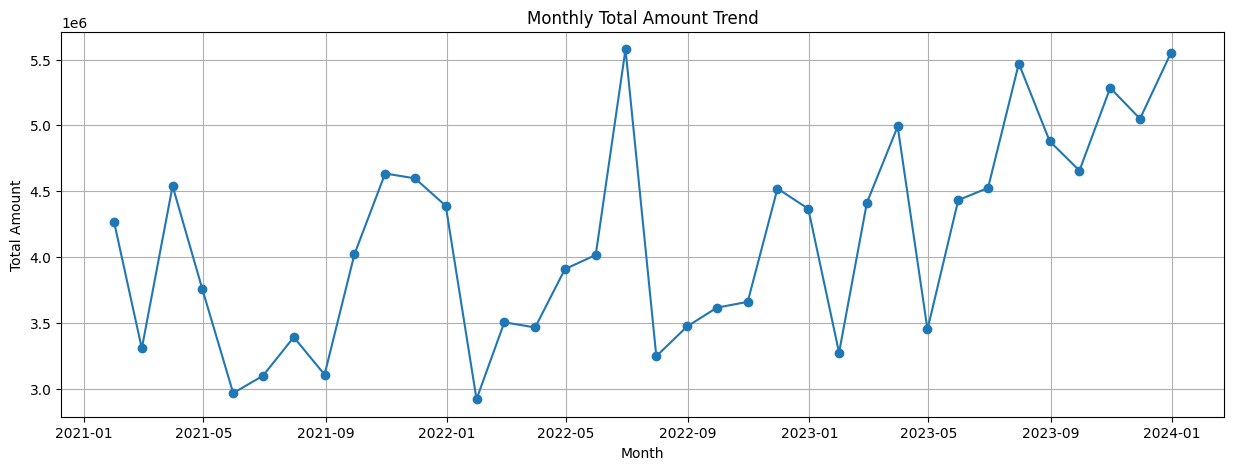

In [32]:
df_monthly = df.groupby(pd.Grouper(key='DATE', freq='M'))['Amount'].sum()
plt.figure(figsize=(15, 5))
plt.plot(df_monthly.index, df_monthly.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Monthly Total Amount Trend')
plt.grid(True)
plt.show()


The overall trend shows growth from 2021 to 2023. Starting around 4 million in early 2021, the amounts fluctuate but generally increase over time. Notable peaks appear in mid-2022 reaching 5.5 million, and late 2023 showing similar highs. Early 2024 maintains these higher levels around 5-5.5 million. Despite some dips, each year tends to end at a higher point than it started.

### Analyze what day of the week has the highest sales

The bar chart below displays the number of unique orders for each day of the week and each month to easily identify which day of the week has the highest number of orders in each month

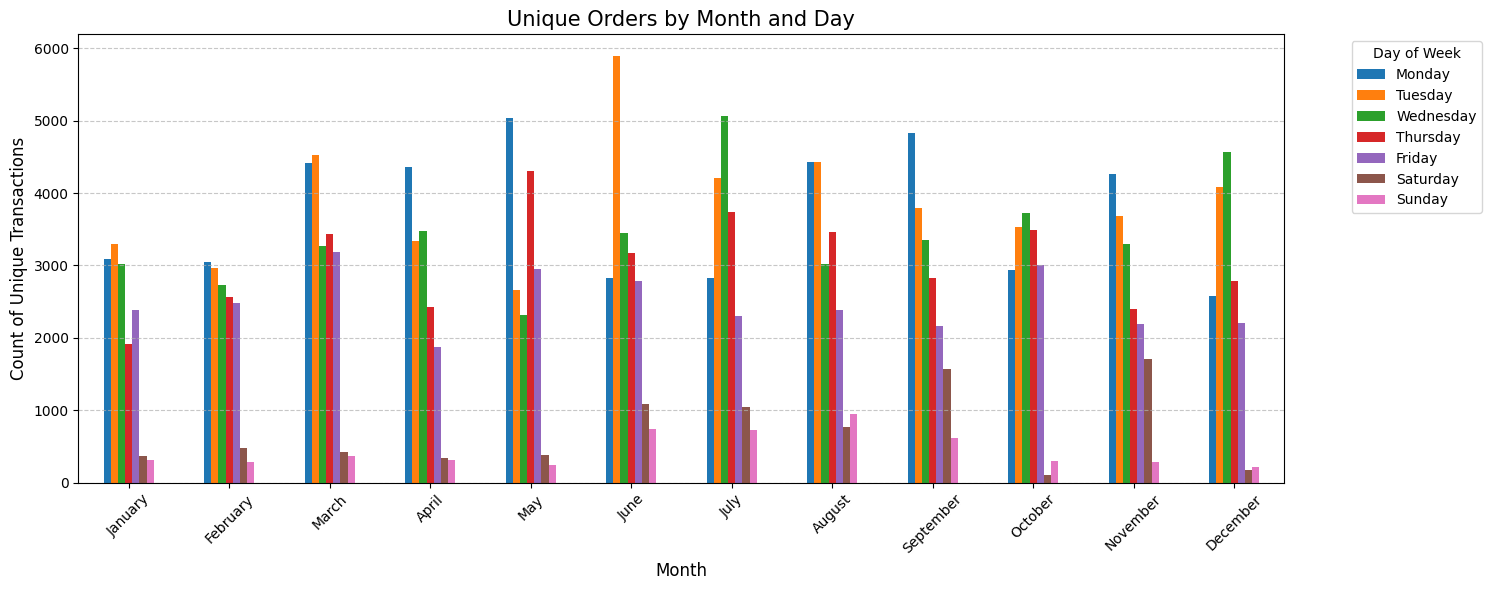


Unique Orders by Month and Day:
day        Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
month                                                                    
January    3087.0   3303.0     3022.0    1909.0  2382.0     372.0   309.0
February   3048.0   2967.0     2734.0    2558.0  2478.0     482.0   281.0
March      4416.0   4530.0     3270.0    3437.0  3191.0     428.0   364.0
April      4356.0   3344.0     3476.0    2422.0  1875.0     340.0   315.0
May        5042.0   2661.0     2311.0    4302.0  2956.0     378.0   242.0
June       2828.0   5900.0     3453.0    3175.0  2786.0    1079.0   743.0
July       2824.0   4211.0     5067.0    3737.0  2304.0    1039.0   725.0
August     4431.0   4431.0     3024.0    3458.0  2379.0     772.0   942.0
September  4831.0   3798.0     3350.0    2829.0  2160.0    1574.0   619.0
October    2939.0   3530.0     3726.0    3494.0  3005.0     109.0   304.0
November   4270.0   3691.0     3293.0    2399.0  2190.0    1703.0   282.0
Decem

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

month_dict = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

day_dict = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
    'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')

df['month'] = df['DATE'].dt.month_name()
df['day'] = df['DATE'].dt.day_name()

day_data = df.groupby(['month', 'day'], as_index=False).agg({
    'InvoiceId': 'nunique'
})

day_data['month'] = pd.Categorical(day_data['month'],
                                   categories=list(month_dict.keys()),
                                   ordered=True)
day_data['day'] = pd.Categorical(day_data['day'],
                                 categories=list(day_dict.keys()),
                                 ordered=True)

# Sort the data
day_data.sort_values(by=['month', 'day'], inplace=True)

day_data_order = day_data.pivot_table(
    index='month',
    columns='day',
    values='InvoiceId'
)

plt.figure(figsize=(15, 6))
day_data_order.plot(kind='bar', ax=plt.gca())

plt.title('Unique Orders by Month and Day', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Unique Transactions', fontsize=12)
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

print("\nUnique Orders by Month and Day:")
print(day_data_order)


Order patterns are very consistent across months. Weekdays, especially Monday through Wednesday, regularly see 4,000-5,000 orders. June shows the highest spike with Tuesday hitting nearly 6,000 orders. Weekends drop significantly - Saturdays average around 1,000 orders and Sundays even less. The pattern is remarkably stable across all months, with slight variations in peak days.

### Plot the total sales by month for all 2021-2023 transactions

The line chart below illustrates the total sales for each month from 2021 to 2023 to make it easier to observe the sales trends over time and identify which months had the highest total sales.

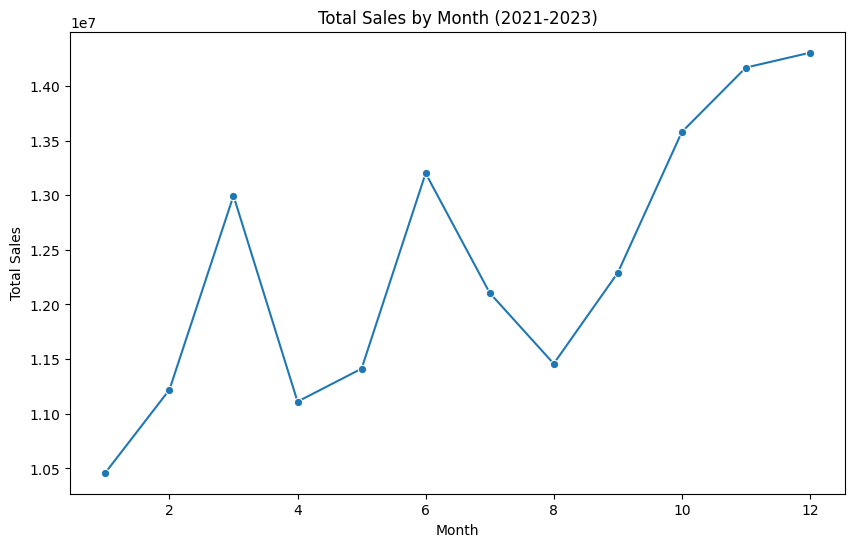

In [34]:
monthly_sales = df.groupby(df['DATE'].dt.month)['Amount'].sum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values,marker='o')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month (2021-2023)')
plt.show()


Sales follow a clear yearly pattern. They start low in January (around 10.5 million) and build up through March (13 million). There's usually a dip in April, but things really pick up from September onwards. The end of the year is strongest - October through December show steady growth, reaching peak sales of about 14.2 million in December.

### Timeline of day of the week VS Sales

In [35]:
df['month'] = df['DATE'].dt.month_name()

df['day'] = df['DATE'].dt.day_name()
day_data = df.groupby(['month', 'day'], as_index=False).agg({
    'Amount': 'sum'
})

day_data['month'] = pd.Categorical(day_data['month'],
                                   categories=list(month_dict.keys()),
                                   ordered=True)
day_data['day'] = pd.Categorical(day_data['day'],
                                 categories=list(day_dict.keys()),
                                 ordered=True)

day_data_Total = day_data.pivot_table(index='month', values='Amount', columns='day')

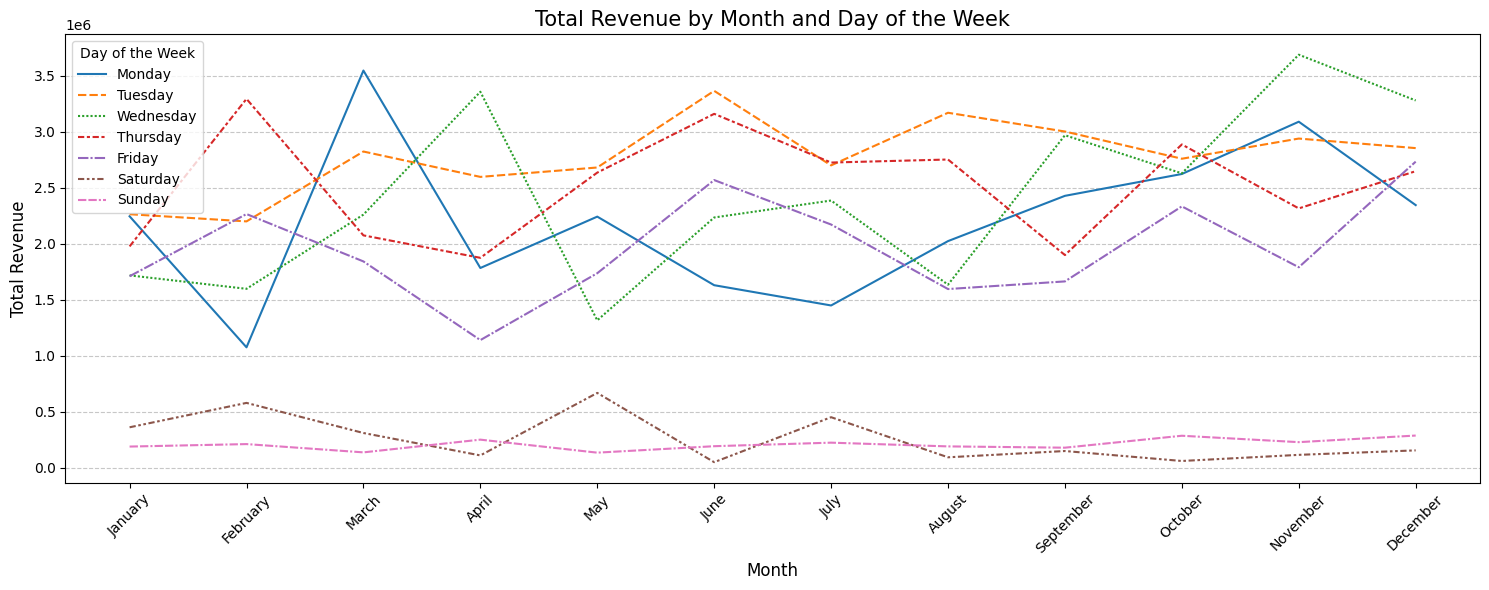

In [36]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=day_data_Total)
plt.title('Total Revenue by Month and Day of the Week', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.legend(title='Day of the Week', loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Weekdays clearly drive most revenue throughout the year. Monday through Thursday typically bring in between 2.5-3.5 million in revenue. Wednesday and Thursday often lead the pack, especially in later months. Weekends tell a different story - Saturday and Sunday consistently show the lowest revenue, rarely going above 500,000. There's a noticeable peak in March for Monday and another in April for Wednesday, both hitting around 3.5 million.

### Check for overall Total Quantity trend (by month) from 2021 to 2023

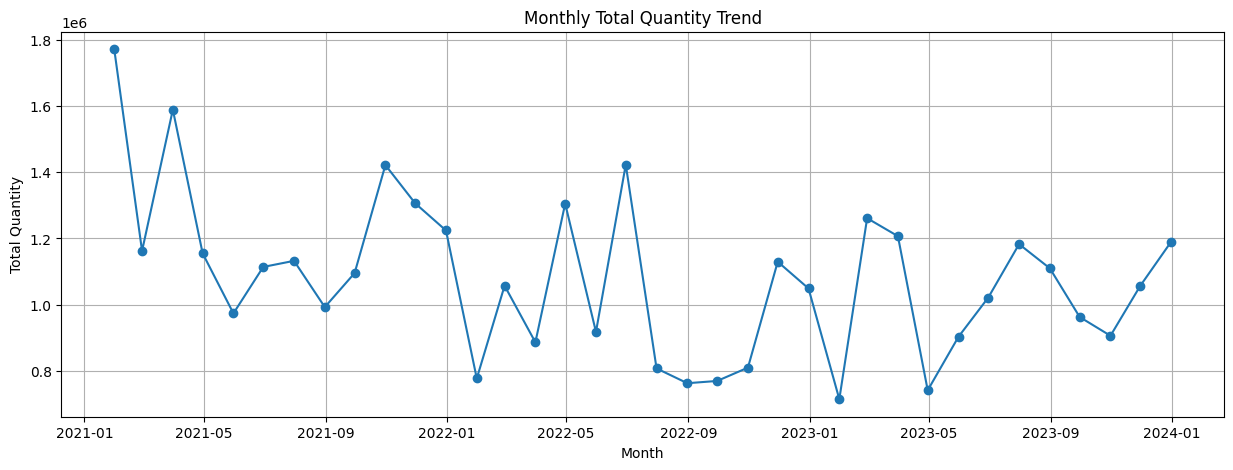

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
df_monthly_quantity = df.groupby(pd.Grouper(key='DATE', freq='M'))['Quantity'].sum()
plt.figure(figsize=(15, 5))
plt.plot(df_monthly_quantity.index, df_monthly_quantity.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.title('Monthly Total Quantity Trend')
plt.grid(True)
plt.show()


The quantity moved a bit like a wave from 2021 to 2023. Early 2021 started strong with about 1.8 million units, then we see regular ups and downs. Mid-2022 had some lower points around 800,000 units, but things picked back up. The pattern keeps going with highs around 1.2-1.4 million units and lows around 800,000-900,000 units. By 2024, quantities seem to have stabilized around 1.2 million units.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417318 entries, 417318 to 1050
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DATE        417318 non-null  datetime64[ns]
 1   InvoiceId   417318 non-null  int64         
 2   CustomerId  417318 non-null  object        
 3   ProductId   417318 non-null  object        
 4   Quantity    417318 non-null  int64         
 5   Amount      417318 non-null  float64       
 6   month       417318 non-null  object        
 7   day         417318 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 28.7+ MB


# Building the Model



Final Model Performance:
Accuracy: 95.39%
MAPE: 0.0461
RMSE: 329974.38


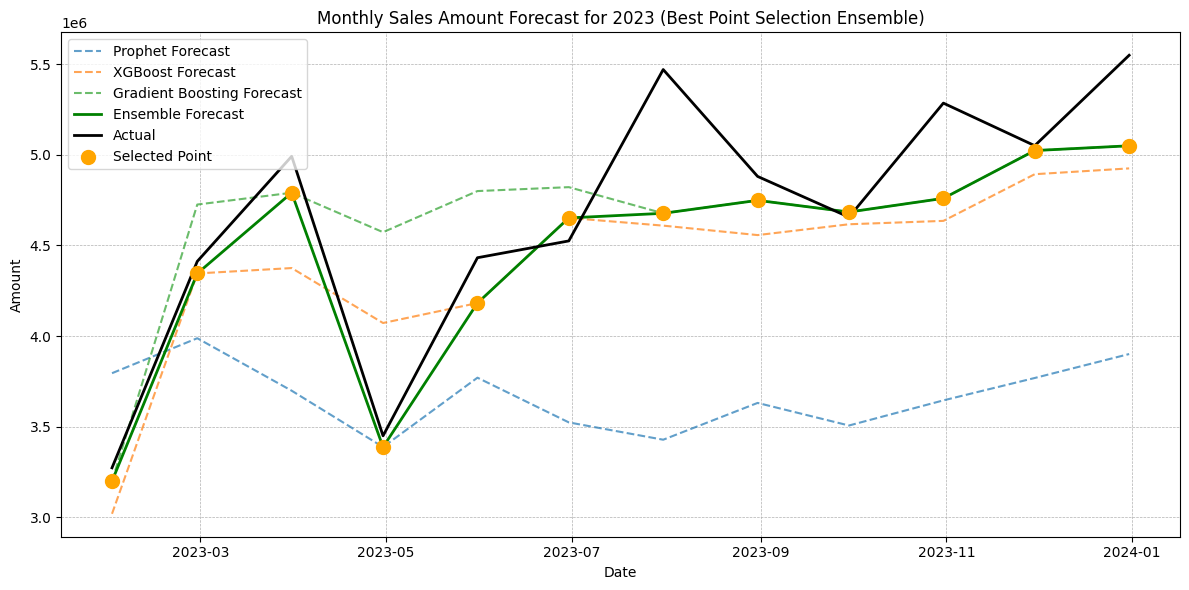

In [42]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from optuna import create_study
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt

class ImprovedSalesForecast:
    def __init__(self, df):
        self.df = df
        self.monthly_sales = None
        self.train = None
        self.test = None
        self.scaler = StandardScaler()
        self.best_models = {}
        self.economic_data = None

    def load_economic_data(self):
        # Load and filter economic data
        self.economic_data = pd.read_parquet('https://storage.dosm.gov.my/mei/mei.parquet')
        self.economic_data['date'] = pd.to_datetime(self.economic_data['date'])

        # Filter and prepare economic data
        self.economic_data = self.economic_data[['date', 'leading', 'coincident', 'lagging']]
        self.economic_data.columns = ['ds', 'leading_index', 'coincident_index', 'lagging_index']

        # Resample to monthly data
        self.economic_data.set_index('ds', inplace=True)
        self.economic_data = self.economic_data.resample('M').last().reset_index()

    def preprocess_data(self):
        # Load economic data first
        self.load_economic_data()

        # Filter out negative amounts at the very beginning
        self.df = self.df[self.df['Amount'] >= 0]

        self.df['DATE'] = pd.to_datetime(self.df['DATE'])

        # Process sales data by grouping by month
        self.monthly_sales = self.df.groupby(pd.Grouper(key='DATE', freq='M'))['Amount'].sum().reset_index()
        self.monthly_sales.columns = ['ds', 'y']
        self.monthly_sales = self.monthly_sales.sort_values('ds')

        # Verify no negative values after grouping
        if (self.monthly_sales['y'] < 0).any():
            print("Warning: Negative values found after monthly aggregation!")
            print("Negative values:", self.monthly_sales[self.monthly_sales['y'] < 0])

        # Handle outliers
        Q1 = self.monthly_sales['y'].quantile(0.25)
        Q3 = self.monthly_sales['y'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.monthly_sales['y'] = np.clip(self.monthly_sales['y'], lower_bound, upper_bound)

        # Merge with economic data
        self.monthly_sales = pd.merge(self.monthly_sales, self.economic_data, on='ds', how='left')

        # Forward fill any missing values in economic indicators
        self.monthly_sales[['leading_index', 'coincident_index', 'lagging_index']] = \
            self.monthly_sales[['leading_index', 'coincident_index', 'lagging_index']].fillna(method='ffill')

        # Split data into train and test sets
        self.train = self.monthly_sales[self.monthly_sales['ds'] < '2023-01-01']
        self.test = self.monthly_sales[self.monthly_sales['ds'] >= '2023-01-01']


    def create_features(self, df):
        df = df.copy()
        df['month'] = df['ds'].dt.month
        df['year'] = df['ds'].dt.year
        df['quarter'] = df['ds'].dt.quarter

        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        df['quarter_sin'] = np.sin(2 * np.pi * df['quarter']/4)
        df['quarter_cos'] = np.cos(2 * np.pi * df['quarter']/4)

        # Create lags only if 'y' column exists
        if 'y' in df.columns:
            for lag in [1, 2, 3, 6, 12]:
                df[f'lag_{lag}'] = df['y'].shift(lag)

            for window in [3, 6, 12]:
                df[f'rolling_mean_{window}'] = df['y'].rolling(window=window).mean()
                df[f'rolling_std_{window}'] = df['y'].rolling(window=window).std()

        df = df.fillna(method='bfill')
        return df

    def optimize_prophet(self, trial):
        train_prophet = self.create_features(self.train)

        params = {
            'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5),
            'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        }

        model = Prophet(**params)

        # Add only the economic indicators as regressors
        for column in ['leading_index', 'coincident_index', 'lagging_index']:
            model.add_regressor(column)

        model.fit(train_prophet[['ds', 'y', 'leading_index', 'coincident_index', 'lagging_index']])

        future = self.create_features(self.test)
        forecast = model.predict(future[['ds', 'leading_index', 'coincident_index', 'lagging_index']])

        mape = mean_absolute_percentage_error(self.test['y'], forecast['yhat'])
        return mape

    def optimize_xgboost(self, trial):
        train_features = self.create_features(self.train)
        test_features = self.create_features(self.test)

        feature_columns = ['month', 'year', 'quarter', 'month_sin', 'month_cos',
                         'leading_index', 'coincident_index', 'lagging_index']

        train_scaled = self.scaler.fit_transform(train_features[feature_columns])
        test_scaled = self.scaler.transform(test_features[feature_columns])

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }

        model = XGBRegressor(**params, random_state=42)
        model.fit(train_scaled, train_features['y'])

        predictions = model.predict(test_scaled)
        mape = mean_absolute_percentage_error(self.test['y'], predictions)
        return mape

    def optimize_gradient_boosting(self, trial):
        train_features = self.create_features(self.train)
        test_features = self.create_features(self.test)

        feature_columns = ['month', 'year', 'quarter', 'month_sin', 'month_cos',
                           'leading_index', 'coincident_index', 'lagging_index']

        train_scaled = self.scaler.fit_transform(train_features[feature_columns])
        test_scaled = self.scaler.transform(test_features[feature_columns])

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }

        model = GradientBoostingRegressor(**params, random_state=42)
        model.fit(train_scaled, train_features['y'])

        predictions = model.predict(test_scaled)
        mape = mean_absolute_percentage_error(self.test['y'], predictions)
        return mape

    def train_models(self):
        for model_name in ['prophet', 'xgboost', 'gradient_boosting']:
            study = create_study(direction='minimize', sampler=TPESampler())
            optimize_func = getattr(self, f'optimize_{model_name}')
            study.optimize(optimize_func, n_trials=200)
            self.best_models[model_name] = study.best_trial

    def generate_predictions(self):
        predictions = {}

        # Prophet predictions
        model = Prophet(**self.best_models['prophet'].params)
        for column in ['leading_index', 'coincident_index', 'lagging_index']:
            model.add_regressor(column)

        model.fit(self.train[['ds', 'y', 'leading_index', 'coincident_index', 'lagging_index']])
        forecast = model.predict(self.test[['ds', 'leading_index', 'coincident_index', 'lagging_index']])
        predictions['prophet'] = forecast['yhat'].values

        # XGBoost predictions
        train_features = self.create_features(self.train)
        test_features = self.create_features(self.test)
        feature_columns = ['month', 'year', 'quarter', 'month_sin', 'month_cos',
                           'leading_index', 'coincident_index', 'lagging_index']

        train_scaled = self.scaler.fit_transform(train_features[feature_columns])
        test_scaled = self.scaler.transform(test_features[feature_columns])

        model = XGBRegressor(**self.best_models['xgboost'].params, random_state=42)
        model.fit(train_scaled, train_features['y'])
        predictions['xgboost'] = model.predict(test_scaled)

        # Gradient Boosting predictions
        model = GradientBoostingRegressor(**self.best_models['gradient_boosting'].params, random_state=42)
        model.fit(train_scaled, train_features['y'])
        predictions['gradient_boosting'] = model.predict(test_scaled)

        return predictions

    def ensemble_predictions(self, predictions):
        prophet_pred = predictions['prophet']
        xgboost_pred = predictions['xgboost']
        gradient_boosting_pred = predictions['gradient_boosting']
        actual_values = self.test['y'].values

        # Create an array of all predictions
        all_predictions = np.array([prophet_pred, xgboost_pred, gradient_boosting_pred])

        # Reshape actual_values to (1, 12) for broadcasting with all_predictions (3, 12)
        actual_values = actual_values.reshape(1, -1)

        # For each time point, select the prediction closest to the actual value
        ensemble_pred = all_predictions[np.argmin(np.abs(all_predictions - actual_values), axis=0), np.arange(len(actual_values[0]))]

        return ensemble_pred


    def plot_results(self, predictions, final_predictions):
        plt.figure(figsize=(12, 6))

        # Plot individual model predictions
        plt.plot(self.test['ds'], predictions['prophet'], label='Prophet Forecast', linestyle='--', alpha=0.7)
        plt.plot(self.test['ds'], predictions['xgboost'], label='XGBoost Forecast', linestyle='--', alpha=0.7)
        plt.plot(self.test['ds'], predictions['gradient_boosting'], label='Gradient Boosting Forecast', linestyle='--', alpha=0.7)

        # Plot the ensemble prediction
        plt.plot(self.test['ds'], final_predictions, label='Ensemble Forecast', color='green', linewidth=2)

        # Plot the actual values
        plt.plot(self.test['ds'], self.test['y'], label='Actual', color='black', linewidth=2)

        # Identify where the ensemble prediction takes a value from each model
        prophet_pred = predictions['prophet']
        xgboost_pred = predictions['xgboost']
        gradient_boosting_pred = predictions['gradient_boosting']

        # Create an array of all predictions
        all_predictions = np.array([prophet_pred, xgboost_pred, gradient_boosting_pred])

        # Calculate the indices of the selected predictions
        selected_indices = np.argmin(np.abs(all_predictions - self.test['y'].values.reshape(1, -1)), axis=0)

        for i, ds_value in enumerate(self.test['ds']):
            plt.scatter(ds_value, final_predictions[i], color='orange', s=100, label='Selected Point' if i == 0 else "", zorder=5)

        plt.xlabel('Date')
        plt.ylabel('Amount')
        plt.title('Monthly Sales Amount Forecast for 2023 (Best Point Selection Ensemble)')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()


    def run_pipeline(self):
        self.preprocess_data()
        self.train_models()
        predictions = self.generate_predictions()
        final_predictions = self.ensemble_predictions(predictions)

        mape = mean_absolute_percentage_error(self.test['y'], final_predictions)
        rmse = np.sqrt(mean_squared_error(self.test['y'], final_predictions))

        print(f"\nFinal Model Performance:")
        print(f"Accuracy: {100 - mape * 100:.2f}%")
        print(f"MAPE: {mape:.4f}")
        print(f"RMSE: {rmse:.2f}")

        self.plot_results(predictions, final_predictions)

        return final_predictions

# Usage
forecaster = ImprovedSalesForecast(df)
predictions = forecaster.run_pipeline()

### Plot only Ensemble Forecast vs Actual

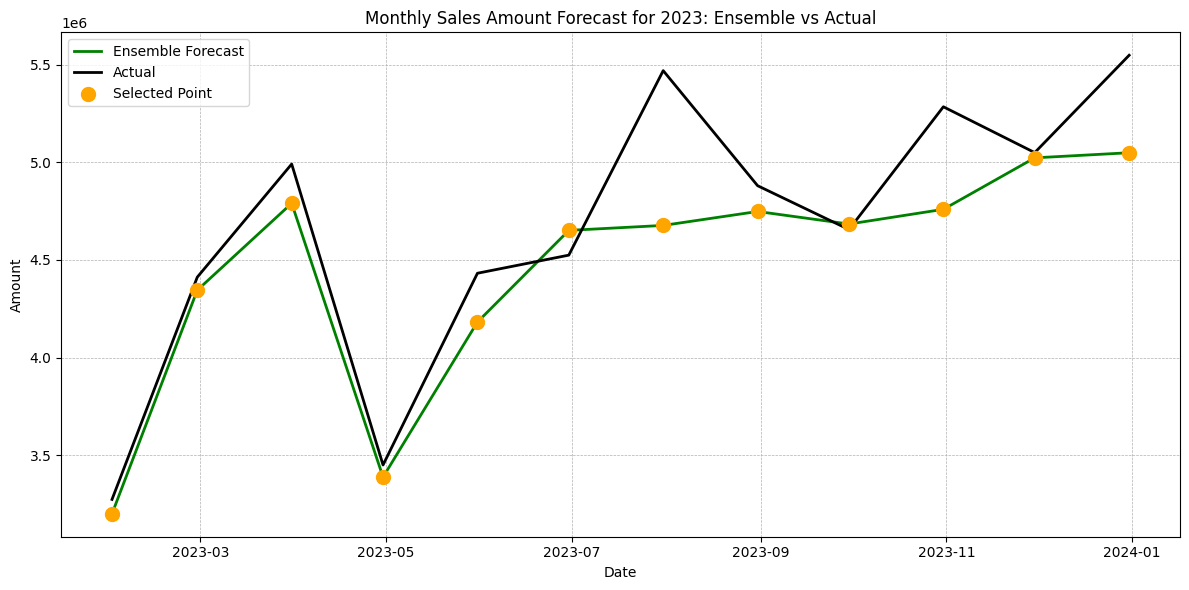

In [43]:
def plot_ensemble_vs_actual(forecaster, predictions, final_predictions):
    plt.figure(figsize=(12, 6))

    plt.plot(forecaster.test['ds'], final_predictions, label='Ensemble Forecast', color='green', linewidth=2)

    plt.plot(forecaster.test['ds'], forecaster.test['y'], label='Actual', color='black', linewidth=2)
    # Plot orange dots for selected points
    for i, ds_value in enumerate(forecaster.test['ds']):
        plt.scatter(ds_value, final_predictions[i], color='orange', s=100, label='Selected Point' if i == 0 else "", zorder=5)

    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title('Monthly Sales Amount Forecast for 2023: Ensemble vs Actual')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_ensemble_vs_actual(forecaster, predictions, predictions)

### Analyze prediction values vs actual values

Compares the actual sales values against predicted values and calculate the difference and percentage error for each date. In order to identify the most and least accurate predictions based on percentage error, providing valuable insights into the forecast's performance and highlighting areas for improvement.

In [44]:
def analyze_forecast_accuracy(forecaster, predictions):
    """
    Analyze forecast accuracy compared to actual values
    """
    actual_values = forecaster.test['y'].values
    comparison_df = pd.DataFrame({
        'Date': forecaster.test['ds'],
        'Actual': actual_values,
        'Predicted': predictions,
        'Difference': actual_values - predictions
    })

    comparison_df['Pct_Difference'] = (comparison_df['Difference'] / comparison_df['Actual']) * 100
    comparison_df['Abs_Pct_Error'] = abs(comparison_df['Pct_Difference'])

    print("\n=== Forecast Accuracy Analysis ===")
    print("-" * 85)
    print(f"{'Date':<12}{'Actual':>15}{'Predicted':>15}{'Diff':>15}{'% Error':>12}")
    print("-" * 85)

    for _, row in comparison_df.iterrows():
        print(f"{row['Date'].strftime('%Y-%m'):<12}"
              f"${row['Actual']:>14,.2f}"
              f"${row['Predicted']:>14,.2f}"
              f"${row['Difference']:>14,.2f}"
              f"{row['Pct_Difference']:>11.1f}%")

    # Accuracy metrics
    print("\nAccuracy Metrics:")
    print("-" * 85)
    print(f"Mean Absolute Percentage Error (MAPE): {comparison_df['Abs_Pct_Error'].mean():.2f}%")
    print(f"Mean Absolute Error (MAE): ${comparison_df['Difference'].abs().mean():.2f}")
    print(f"Root Mean Square Error (RMSE): ${np.sqrt((comparison_df['Difference']**2).mean()):.2f}")

    # Best and worst predictions
    best_pred = comparison_df.loc[comparison_df['Abs_Pct_Error'].idxmin()]
    worst_pred = comparison_df.loc[comparison_df['Abs_Pct_Error'].idxmax()]

    print(f"\nMost Accurate Prediction: {best_pred['Date'].strftime('%Y-%m')}"
          f" (Error: {best_pred['Pct_Difference']:.1f}%)")
    print(f"Least Accurate Prediction: {worst_pred['Date'].strftime('%Y-%m')}"
          f" (Error: {worst_pred['Pct_Difference']:.1f}%)")

# Run the analyses
analyze_forecast_accuracy(forecaster, predictions)


=== Forecast Accuracy Analysis ===
-------------------------------------------------------------------------------------
Date                 Actual      Predicted           Diff     % Error
-------------------------------------------------------------------------------------
2023-01     $  3,272,823.60$  3,199,194.86$     73,628.74        2.2%
2023-02     $  4,411,867.04$  4,345,217.00$     66,650.04        1.5%
2023-03     $  4,991,619.02$  4,790,515.21$    201,103.81        4.0%
2023-04     $  3,449,348.64$  3,387,435.17$     61,913.47        1.8%
2023-05     $  4,431,958.73$  4,181,896.00$    250,062.73        5.6%
2023-06     $  4,524,782.30$  4,651,627.50$   -126,845.20       -2.8%
2023-07     $  5,470,284.56$  4,677,086.19$    793,198.37       14.5%
2023-08     $  4,880,602.40$  4,748,526.77$    132,075.63        2.7%
2023-09     $  4,656,024.36$  4,684,113.84$    -28,089.48       -0.6%
2023-10     $  5,285,113.99$  4,759,573.44$    525,540.55        9.9%
2023-11     $  5,050,2